# Getting Started

### Recommend using a virtual environment (conda is common for ML)

To activate conda env:

    conda activate env_name


### Install required packages

    conda install pytorch torchvision torchaudio -c pytorch

    conda install pandas numpy matplotlib pillow tqdm pygame -c conda-forge

    pip install iterative-stratification timm


### Relevant Resources

Demo .csv Dataset:

https://www.dropbox.com/scl/fi/1tck9b8bab8z3n38m7jio/miml_dataset.zip?rlkey=11nwt23wa40o8iqmp24898d3g&e=5&dl=0 


Pretrained model tutorial:

https://www.kaggle.com/code/gohweizheng/swin-transformer-beginner-friendly-notebook#Pretrained-SWIN-Transformer

Pretrained Swin Transformer models to choose:

https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/swin_transformer.py

## Imports

In [ ]:
import os
import time
import json
import glob
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import requests

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from PIL import Image

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

## Hyperparameters

In [ ]:
# ===============================================================
# Hyperparameters
# ===============================================================

# --- GPU Optimization ---
USE_GPU = True                  

# --- Image Processing ---
IMG_WIDTH = 384    

# --- Training ---
N_EPOCHS = 100                     
BATCH_SIZE = 16                      
LEARNING_RATE = 1e-4                 
PATIENCE = 5    # Early stopping patience.

# --- Partitioning Proportions --- (Ensure total == 1.0)
TRAIN_RATIO = 0.8                   
VAL_RATIO = 0.1                    
TEST_RATIO = 0.1                   
RANDOM_SEED = 42                                 

# Set seeds for reproducibility.
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# GPU Optimization (Setting up device).
if USE_GPU:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

pin_memory = True if (USE_GPU and device.type == 'cuda') else False

Using device: mps


## Load Labels from .csv/.json to DataFrame for Easy Handling

###########################################################################################################################
###########################################################################################################################
### For JSON

In [86]:
# =============================================================================
# Load .json to a DataFrame
# ============================================================================= 
def get_confidence_score(response_str):
    try:
        # Split on space and convert the first element to an integer.
        return int(response_str.split(" ")[0])
    except Exception:
        return None

def parse_classifications(record, threshold):
    labels_positive = {}
    
    # Look into the "projects" dictionary.
    projects = record.get("projects", {})
    for project in projects.values():
        # "labels" is a list under each project.
        for label in project.get("labels", []):
            # Each label has an "annotations" part that contains "classifications".
            annotations = label.get("annotations", {})
            for classification in annotations.get("classifications", []):
                label_name = classification.get("name", None)
                positive = False  # start with negative
                
                # First, check if there are checklist answers.
                checklist = classification.get("checklist_answers", [])
                if checklist:
                    for answer in checklist:
                        score = get_confidence_score(answer.get("name", ""))
                        if score is not None and score <= threshold:
                            positive = True
                            break  # one positive answer is enough
                else:
                    # If no checklist, try to interpret the classification value.
                    val = classification.get("value", "")
                    if val and val[0].isdigit():
                        try:
                            score = int(val[0])
                            if score <= threshold:
                                positive = True
                        except Exception:
                            pass
                if label_name:
                    # If the label already exists, we use an OR logic:
                    # if already marked positive, or current is positive, mark it positive.
                    labels_positive[label_name] = int(labels_positive.get(label_name, 0) or positive)
    return labels_positive


NDJSON_FILE_PATH = 'demo_360.ndjson'
threshold = 3
records = []

with open(NDJSON_FILE_PATH, 'r') as file:
    for line in file:
        record = json.loads(line)
        external_id = record.get("data_row", {}).get("external_id", None)  # Get the external ID from the "data_row" field.
        label_dict = parse_classifications(record, threshold=threshold) # Process the nested classifications.
        
        record_entry = {"external_id": external_id} # Create a dictionary for this record.
        # Merge in the labels (each label will be a column with value 0/1).
        record_entry.update(label_dict)
        records.append(record_entry)

# Convert the processed records into a DataFrame.
df = pd.DataFrame(records)

pd.set_option('display.expand_frame_repr', False)
print(df)


                            external_id  Grass  Water  [Lvl2] Lily  Problematic  Extra Notes  Revisit
0  IMG_20230801_105724_00_880_right.jpg    1.0    1.0          1.0          0.0          0.0      0.0
1  IMG_20230801_105724_00_843_right.jpg    1.0    NaN          1.0          0.0          NaN      NaN
2  IMG_20230801_105724_00_857_right.jpg    1.0    1.0          1.0          NaN          NaN      NaN
3  IMG_20230801_105724_00_738_right.jpg    1.0    1.0          NaN          NaN          NaN      NaN
4  IMG_20230801_105724_00_739_right.jpg    1.0    NaN          NaN          NaN          NaN      NaN
5  IMG_20230801_105724_00_856_right.jpg    NaN    NaN          1.0          NaN          NaN      NaN
6  IMG_20230801_105724_00_842_right.jpg    NaN    NaN          NaN          0.0          NaN      NaN
7  IMG_20230801_105724_00_881_right.jpg    NaN    NaN          NaN          0.0          NaN      0.0
8  IMG_20230801_105724_00_883_right.jpg    1.0    NaN          NaN          NaN   

In [ ]:
# =============================================================================
# Standardize .json DataFrame
# ============================================================================= 
def get_base_filename(filename):
    for suffix in ["_left.jpg", "_right.jpg"]:
        if filename.endswith(suffix):
            return filename[:-len(suffix)] # Remove specified suffix
    return os.path.splitext(filename)[0] # Fallback: Removes extensions

def create_ndjson_image_path_mapping(ndjson_base_dir):
    """
    Recursively scans the NDJSON base directory for JPEG images in any "split_jpg" folder
    and creates a mapping from each image's basename to its full local file path.
    
    Returns:
        dict: Mapping { image_basename: full_image_path }.
    """
    glob_pattern = os.path.join(ndjson_base_dir, "*", "*", "split_jpg", "*.jpg")
    full_paths = glob.glob(glob_pattern, recursive=True)
    mapping = {}
    for full_path in full_paths:
        image_basename = os.path.basename(full_path)
        mapping[image_basename] = full_path
    return mapping

df["group_id"] = df["external_id"].apply(get_base_filename) # Add 'group_id' column using base filenames

NDJSON_IMG_DIR = "360d_imagery_subset"
image_mapping = create_ndjson_image_path_mapping(NDJSON_IMG_DIR)
df["image_path"] = df["external_id"].map(image_mapping) # Add 'image_path' column by mapping the filename to its full file path.

pd.set_option('display.max_colwidth', None)
print(df)

###########################################################################################################################
###########################################################################################################################
### For .csv

In [ ]:
# ===============================================================
# Load .csv to a DataFrame
# ===============================================================
CSV_FILE_PATH = 'miml_dataset/miml_labels_1.csv'  
IMG_DIR = 'miml_dataset/images'     

def load_csv_to_df(csv_filepath, images_dir):
    """
    Reads a CSV file into a dataframe and adds 'group_id' and 'image_path' columns.

    Returns:
        pd.DataFrame: A standardized DataFrame with columns:
                      'Filenames', 'group_id', 'image_path', plus any additional label columns.
    """
    df_csv = pd.read_csv(csv_filepath) 
    df_csv["group_id"] = [os.path.splitext(filename)[0] for filename in df_csv["Filenames"]] # Add 'group_id' by removing the file extension.
    df_csv["image_path"] = [os.path.join(images_dir, filename) for filename in df_csv["Filenames"]] # Add 'image_path' by joining the images_dir with the filename.
    return df_csv     

df = load_csv_to_df(CSV_FILE_PATH, IMG_DIR)
pd.set_option('display.expand_frame_repr', False)
print(df.head())

  Filenames  desert  mountains  sea  sunset  trees group_id                 image_path
0     1.jpg       1          0    0       0      0        1  miml_dataset/images/1.jpg
1     2.jpg       1          0    0       0      0        2  miml_dataset/images/2.jpg
2     3.jpg       1          0    0       0      0        3  miml_dataset/images/3.jpg
3     4.jpg       1          1    0       0      0        4  miml_dataset/images/4.jpg
4     5.jpg       1          0    0       0      0        5  miml_dataset/images/5.jpg


### Fill in empty non-responses (mostly for LabelBox's .json output)

In [90]:
nonlabel_columns = {"external_id", "Filenames", "group_id", "image_path", "Problematic", "Extra Notes", "Revisit"}
label_columns = [col for col in df.columns if col not in nonlabel_columns]

df[label_columns] = df[label_columns].fillna(0) # Fill empty label values with 0.

# Sanity Check
print(f"Label Columns: {label_columns}")
print(df.head())

Label Columns: ['Grass', 'Water', '[Lvl2] Lily']
                            external_id  Grass  Water  [Lvl2] Lily  Problematic  Extra Notes  Revisit
0  IMG_20230801_105724_00_880_right.jpg    1.0    1.0          1.0          0.0          0.0      0.0
1  IMG_20230801_105724_00_843_right.jpg    1.0    0.0          1.0          0.0          0.0      0.0
2  IMG_20230801_105724_00_857_right.jpg    1.0    1.0          1.0          0.0          0.0      0.0
3  IMG_20230801_105724_00_738_right.jpg    1.0    1.0          0.0          0.0          0.0      0.0
4  IMG_20230801_105724_00_739_right.jpg    1.0    0.0          0.0          0.0          0.0      0.0


## Partition Data and Labels into Train/Validation/Test Sets

In [ ]:
# ===============================================================
# Stratification
# ===============================================================
def group_stratified_split(df, label_cols, group_col, split_ratio, seed):
    """
    Splits the DataFrame into two subsets in a group-aware manner.
    For each unique group (defined by group_col), this function 
    aggregates the label vectors, and then performs a stratified split 
    based on these aggregated multilabel targets.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        label_cols (list): List of columns representing multilabel targets.
        group_col (str): Column name used to group the data (ie "group_id").
        split_ratio (float): Proportion of groups to use in the "second" split.
        seed (int): Random seed for reproducibility.
        
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Two DataFrame splits (first split and second split).
    """
    unique_groups = df[group_col].unique()
    aggregated_labels = [] 
    for group in unique_groups:
        group_df = df[df[group_col] == group] # Extract the subset of rows for this group.
        agg_labels = group_df[label_cols].max()  # Use max() across rows for each label column to simulate a logical OR
        aggregated_labels.append(agg_labels)

    unique_groups_array = np.array(unique_groups)
    aggregated_labels_array = np.array(aggregated_labels)
    # Initialize the multilabel stratified shuffle split with the desired test size and random seed.
    splitter = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=split_ratio, random_state=seed)
    
    # Use the splitter to get indices for train and test groups based on the aggregated labels.
    for first_split_idx, second_split_idx in splitter.split(unique_groups_array.reshape(-1, 1), aggregated_labels_array):
        first_groups = unique_groups_array[first_split_idx]
        second_groups = unique_groups_array[second_split_idx]
    
     # Create the final DataFrame splits by selecting rows that belong to each group split.
    df_split_1 = df[df[group_col].isin(first_groups)].reset_index(drop=True)
    df_split_2 = df[df[group_col].isin(second_groups)].reset_index(drop=True)
    return df_split_1, df_split_2

# First, split off the test set.
df_train_val, df_test = group_stratified_split(df, label_columns, group_col="group_id", split_ratio=TEST_RATIO, seed=RANDOM_SEED)
# Next, split train/validation.
relative_val_ratio = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
df_train, df_val = group_stratified_split(df_train_val, label_columns, group_col="group_id", split_ratio=relative_val_ratio, seed=RANDOM_SEED)

print("Unified split sizes (by group):")
print("Train groups:", len(df_train))
print("Validation groups:", len(df_val))
print("Test groups:", len(df_test))

Unified split sizes (by group):
Train groups: 1597
Validation groups: 205
Test groups: 198


In [ ]:
TRAIN_PARTITION_FILE = 'train_partitions.csv'
VAL_PARTITION_FILE = 'val_partitions.csv'
TEST_PARTITION_FILE = 'test_partitions.csv'

# Save DataFrame splits to .csv
df_train.to_csv(TRAIN_PARTITION_FILE, index=False)
df_val.to_csv(VAL_PARTITION_FILE, index=False)
df_test.to_csv(TEST_PARTITION_FILE, index=False)

# Load DataFrames from .csv
df_train = pd.read_csv(TRAIN_PARTITION_FILE)
df_val = pd.read_csv(VAL_PARTITION_FILE)
df_test = pd.read_csv(TEST_PARTITION_FILE)

print("Partition files loaded.")

Partition files loaded.



Label distribution in Original Dataset:
  desert: 20.45% positive
  mountains: 22.90% positive
  sea: 29.00% positive
  sunset: 23.25% positive
  trees: 28.00% positive


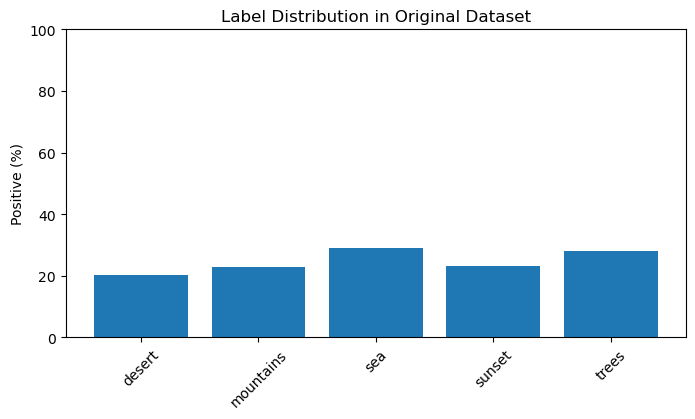


Label distribution in Train:
  desert: 20.48% positive
  mountains: 22.92% positive
  sea: 29.05% positive
  sunset: 23.29% positive
  trees: 28.05% positive


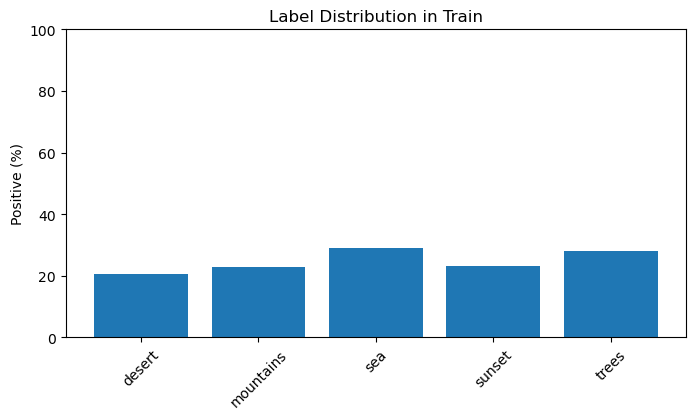


Label distribution in Validation:
  desert: 20.00% positive
  mountains: 22.44% positive
  sea: 28.29% positive
  sunset: 22.93% positive
  trees: 27.32% positive


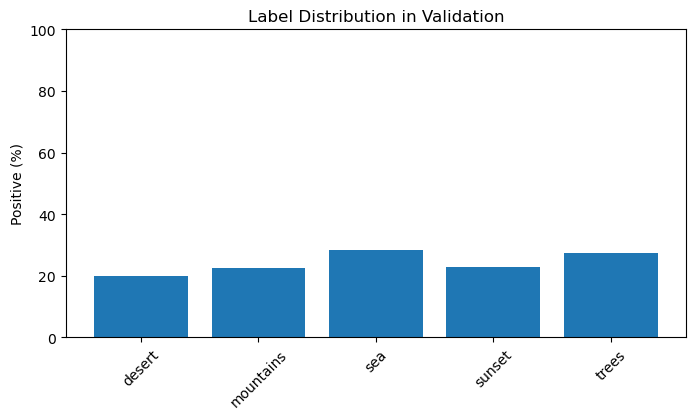


Label distribution in Test:
  desert: 20.71% positive
  mountains: 23.23% positive
  sea: 29.29% positive
  sunset: 23.23% positive
  trees: 28.28% positive


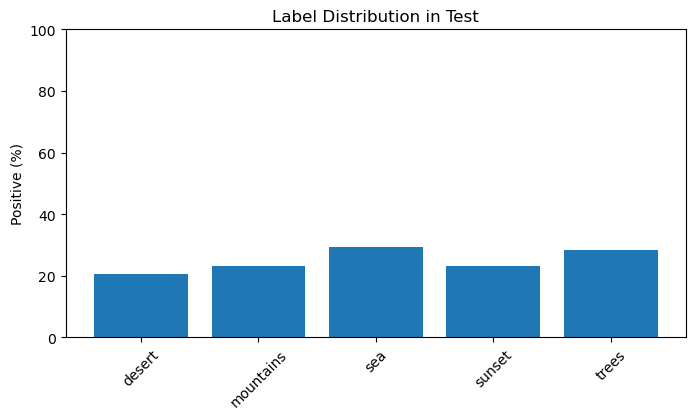

In [10]:
def show_label_distribution(df, label_columns, partition_name="Dataset"):
    """
    Prints and plots the positive percentage for each label.
    """
    print(f"\nLabel distribution in {partition_name}:")
    positive_rates = {}
    for label in label_columns:
        pos_rate = df[label].mean() * 100
        positive_rates[label] = pos_rate
        print(f"  {label}: {pos_rate:.2f}% positive")
    plt.figure(figsize=(8,4))
    plt.bar(positive_rates.keys(), positive_rates.values())
    plt.ylabel("Positive (%)")
    plt.title(f"Label Distribution in {partition_name}")
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.show()
    
# Visualize the label distribution across the entire dataset.
show_label_distribution(df, label_columns, partition_name="Original Dataset")
# Check Label Ratios Across Train/Valid/Test 
show_label_distribution(df_train, label_columns, partition_name="Train")
show_label_distribution(df_val, label_columns, partition_name="Validation")
show_label_distribution(df_test, label_columns, partition_name="Test")

## Dataset and Image Processing

In [ ]:
# ===============================================================
# Dataset Class 
# ===============================================================
class DataPartition(Dataset):
    def __init__(self, data_frame, transform=None):
        """
        Initializes the dataset with the DataFrame and data augmentation pipeline.

        Args:
            data_frame (pd.DataFrame): The DataFrame with image paths and label columns.
            transform (callable, optional): A torchvision transformation pipeline to apply 
                                            to the images.
        """
        self.df = data_frame.copy()  # Copy DataFrame to avoid modifying the original.
        self.transform = transform
        self.samples = [] # Build a list of tuples: (image_path, label_vector)
        for _, row in self.df.iterrows():
            image_path = row["image_path"]
            label_vector = row[label_columns].values.astype(np.float32)
            self.samples.append((image_path, label_vector))
    
    def __len__(self):
        # Return the total number of samples.
        return len(self.samples)
    
    def __getitem__(self, index):
        # Retrieve the image path and corresponding label vector.
        image_path, label_vector = self.samples[index]
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as error:
            raise RuntimeError(f"Error loading image from {image_path}: {error}")
        # Apply image transformations.
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label_vector, dtype=torch.float32)


# ===============================================================
# Data Augmentation
# ===============================================================
train_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(p=0.5),# Randomly flip images horizontally (50% chance).
    # Apply a mild random affine transformation.
    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=10,         # small rotation: rotate within [-10, 10] degrees
            translate=(0.05, 0.05),  # small translation: shift up to 5% of the image dimensions
            scale=(0.95, 1.05)       # slightly zoom in or out
        )
    ], p=0.5),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    # Randomly add a slight Gaussian blur.
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_WIDTH)),
    transforms.ToTensor(),                           # Convert the PIL Image to a PyTorch Tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize using ImageNet statistics.
                         std=[0.229, 0.224, 0.225])
])


# ===============================================================
# Create Dataset Objects for Training, Validation, and Testing
# ===============================================================
train_dataset = DataPartition(df_train, transform=train_transforms)
val_dataset   = DataPartition(df_val, transform=val_transforms)
test_dataset  = DataPartition(df_test, transform=val_transforms)


## Dataloaders

In [23]:
# ===============================================================
# Determine Optimal Number of DataLoader Workers
# ===============================================================
def find_optimal_num_workers(dataset_obj, batch_size, candidate_workers=[0, 2, 4, 8]):
    """
    Benchmarks various num_workers values and returns the optimal count for the DataLoader.
    
    Args:
        dataset_obj (Dataset): The dataset instance to benchmark.
        batch_size (int): The batch size for DataLoader.
        candidate_workers (list): List of candidate worker counts.
        
    Returns:
        int: The optimal number of DataLoader workers.
    """
    best_time = float("inf")
    optimal_workers = candidate_workers[0]
    for workers in candidate_workers:
        loader = DataLoader(dataset_obj, batch_size=batch_size, num_workers=workers, pin_memory=pin_memory)
        start_time = time.time()
        # Loop over a few batches to simulate runtime.
        for i, _ in enumerate(loader):
            if i == 20:
                break
        elapsed = time.time() - start_time
        print(f"num_workers = {workers}, time for 20 batches = {elapsed:.2f} sec")
        if elapsed < best_time:
            best_time = elapsed
            optimal_workers = workers
    return optimal_workers

# Benchmark and choose the optimal number of workers.
if USE_GPU and device.type == 'cuda':
    print("Benchmarking DataLoader num_workers for training dataset...")
    optimal_num_workers = find_optimal_num_workers(dataset_train, BATCH_SIZE)
else:
    optimal_num_workers = 0
print(f"Optimal num_workers: {optimal_num_workers}")


# ===============================================================
# Create DataLoaders for Training, Validation, and Testing
# ===============================================================
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                            num_workers=optimal_num_workers, pin_memory=pin_memory)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=optimal_num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=optimal_num_workers, pin_memory=pin_memory)

# Display the number of samples in each set.
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Optimal num_workers: 0
Train samples: 1597
Validation samples: 205
Test samples: 198


## Model

In [ ]:
# ===============================================================
# Model Architecture
# ===============================================================
NUM_CLASSES = len(label_columns)

class SwinTransformerMultiLabel(nn.Module):
    def __init__(self, num_classes, pretrained=True, dropout_rate=0.5):
        super(SwinTransformerMultiLabel, self).__init__()
        self.model = timm.create_model("swin_base_patch4_window12_384_22kto1k", pretrained=pretrained)
        in_features = self.model.head.in_features
        
        self.model.head = nn.Identity()  # Remove the original head.
        self.dropout = nn.Dropout(dropout_rate)  # Add our dropout layer.
        self.fc = nn.Linear(in_features, num_classes)# Then add our new classification head.
    
    def forward(self, x):
        features = self.model(x)
        features = self.dropout(features)
        return self.fc(features)

model = SwinTransformerMultiLabel(num_classes=NUM_CLASSES, pretrained=True, dropout_rate=dropout_rate).to(device)
print(model)


/opt/anaconda3/envs/360deg_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/360deg_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50MultiLabel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

## Training

In [ ]:
# ===============================================================
# Training Monitor
# ===============================================================
class TrainingMonitor:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.val_mAPs = []  
        self.start_time = time.time()
    
    def report_epoch(self, epoch, train_loss, train_acc, val_loss, val_acc, val_map):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accuracies.append(train_acc)
        self.val_accuracies.append(val_acc)
        self.val_mAPs.append(val_map)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%  |  "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%, mAP: {val_map:.4f}")
    
    def finish(self):
        total_time = time.time() - self.start_time
        print(f"Total training time: {total_time:.2f} seconds")
        return total_time
    
    def plot(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 5))
        # Loss curves
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Train Loss")
        plt.plot(epochs, self.val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss Curves")
        plt.legend()
        plt.grid(True)
        # Accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label="Train Accuracy")
        plt.plot(epochs, self.val_accuracies, label="Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Curves")
        plt.legend()
        plt.grid(True)
        plt.show()
        # Plot Validation mAP.
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.val_mAPs, label="Validation mAP", color="green")
        plt.xlabel("Epochs")
        plt.ylabel("mAP")
        plt.title("Validation mAP Curve")
        plt.legend()
        plt.grid(True)


In [ ]:
# ===============================================================
# Training Loop (Trainer class)
# ===============================================================
class Trainer:
    def __init__(self, model, optimizer, scheduler, criterion, train_loader, val_loader, test_loader, device, monitor, patience=PATIENCE):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.monitor = monitor
        self.patience = patience
        self.best_val_loss = float('inf')
        self.epochs_no_improve = 0
        self.best_model_state = None

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct_preds = 0
        total_count = 0
        for images, labels in self.train_loader:
            images = images.to(self.device)
            labels = labels.to(self.device)
            logits = self.model(images)  # Forward pass
            loss = self.criterion(logits, labels)  # Compute loss
            self.optimizer.zero_grad()  # Reset gradients
            loss.backward()  # Backpropagation
            self.optimizer.step()  # Update weights
            running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct_preds += (preds == labels).sum().item()
            total_count += labels.numel()
        epoch_loss = running_loss / total_count
        epoch_accuracy = correct_preds / total_count
        return epoch_loss, epoch_accuracy

    def validate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_count = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                running_loss += loss.item() * images.size(0)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()
                correct_preds += (preds == labels).sum().item()
                total_count += labels.numel()

                # Accumulate predictions and true labels for mAP computation.
                all_preds.append(probs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
                
        val_loss = running_loss / total_count
        val_accuracy = correct_preds / total_count

        # Concatenate predictions and labels.
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # Compute Average Precision for each class and then the mean over all classes.
        from sklearn.metrics import average_precision_score
        ap_scores = []
        for i in range(all_labels.shape[1]):
            try:
                ap = average_precision_score(all_labels[:, i], all_preds[:, i])
            except Exception:
                ap = 0.0  # In case of errors (e.g., no positive samples for a class)
            ap_scores.append(ap)
        mAP = np.mean(ap_scores)
        print(f"Validation mAP: {mAP:.4f}")
        return val_loss, val_accuracy, mAP

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            start_time = time.time()
            train_loss, train_acc = self.train_epoch()
            # Now returns mAP along with loss and accuracy.
            val_loss, val_acc, val_map = self.validate_epoch()
            elapsed = time.time() - start_time
            print(f"Epoch {epoch+1}/{num_epochs}   ({elapsed:.2f} sec)")
            self.monitor.report_epoch(epoch, train_loss, train_acc, val_loss, val_acc, val_map)
            self.scheduler.step()
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_model_state = self.model.state_dict()
                self.epochs_no_improve = 0
                print(f"New best model saved at epoch {epoch+1} with val loss: {val_loss:.4f}\n")
                torch.save(self.best_model_state, "best_model.pt")
            else:
                self.epochs_no_improve += 1
                if self.epochs_no_improve >= self.patience:
                    print("Early stopping triggered.")
                    break
        total_train_time = self.monitor.finish()
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
        return total_train_time

    def test(self):
        self.model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_count = 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                running_loss += loss.item() * images.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                correct_preds += (preds == labels).sum().item()
                total_count += labels.numel()
        test_loss = running_loss / total_count
        test_accuracy = correct_preds / total_count
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
        return test_loss, test_accuracy


## Classifier Wrapper

In [ ]:
# ===============================================================
# Classifier Class
# ===============================================================
class Classifier:
    def __init__(self, model, transform, device, threshold=0.5, categories=None):
        """
        Allows the trained CNN to be saved to disk and loaded back in.
        """
        self.model = model.to(device)
        self.model.eval()
        self.transform = transform
        self.device = device
        self.threshold = threshold
        self.categories = categories if categories is not None else []
    
    def predict(self, image):
        """
        Predicts binary labels for a single image.
        
        Args:
            image (PIL.Image): The input image.
            
        Returns:
            np.array: Binary predictions for each label.
        """
        img_tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits = self.model(img_tensor)
            probs = torch.sigmoid(logits)
            binary_preds = (probs >= self.threshold).float()
        return binary_preds.cpu().numpy()
    
    def batch_predict(self, image_list):
        """
        Predicts binary labels for a list of images.
        
        Args:
            image_list (list): List of PIL.Image objects.
            
        Returns:
            np.array: Binary predictions for each image.
        """
        transformed_imgs = [self.transform(img) for img in image_list]
        img_tensor = torch.stack(transformed_imgs).to(self.device)
        with torch.no_grad():
            logits = self.model(img_tensor)
            probs = torch.sigmoid(logits)
            binary_preds = (probs >= self.threshold).float()
        return binary_preds.cpu().numpy()
    
    def save(self, base_filename):
        """
        Saves the model weights and configuration to disk.
        
        Args:
            base_filename (str): Base filename (without extension) for saving.
        """
        torch.save(self.model.state_dict(), base_filename + ".pt")
        config = {"threshold": self.threshold, "categories": self.categories}
        with open(base_filename + ".json", "w") as config_file:
            json.dump(config, config_file)
        print(f"Model saved to {base_filename}.pt and {base_filename}.json.")
    
    @staticmethod
    def load(config_filename, transform, device):
        """
        Loads a saved model and configuration from disk.
        
        Args:
            config_filename (str): Path to the JSON configuration file.
            transform (callable): Preprocessing transform.
            device (torch.device): Computation device.
            
        Returns:
            Classifier: A new Classifier instance.
        """
        with open(config_filename, "r") as f:
            config = json.load(f)
        categories = config.get("categories", [])
        num_classes = len(categories)
        loaded_model = SwinTransformerMultiLabel(num_classes=num_classes, pretrained=True).to(device)
        state_dict_filename = config_filename.replace(".json", ".pt")
        loaded_model.load_state_dict(torch.load(state_dict_filename, map_location=device))
        print(f"Model loaded from {state_dict_filename} and {config_filename}.")
        return Classifier(loaded_model, transform, device, threshold=config.get("threshold", 0.5), categories=categories)


In [ ]:
# ===============================================================
# Run/Execute
# ===============================================================
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.05, amsgrad=False)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=params['T_0'], eta_min=params['min_lr'], last_epoch=-1)
monitor = TrainingMonitor()

trainer = Trainer(model, optimizer, scheduler, loss_function,
                  train_loader, val_loader, device, monitor, patience=PATIENCE)
total_training_time = trainer.train(N_EPOCHS)
print("Training complete. Best model loaded.")

## Plot Loss & Accuracies

In [ ]:
monitor.plot()

## Evaluate Test Set

In [ ]:
trainer.test(test_loader)

## Classifier Wrapper

In [ ]:
# ===============================================================
# Classifier Class
# ===============================================================
class Classifier:
    def __init__(self, model, transform, device, threshold=0.5, categories=None):
        """
        Allows the trained CNN to be saved to disk and loaded back in.
        """
        self.model = model.to(device)
        self.model.eval()
        self.transform = transform
        self.device = device
        self.threshold = threshold
        self.categories = categories if categories is not None else []
    
    def predict(self, image):
        """
        Predicts binary labels for a single image.
        
        Args:
            image (PIL.Image): The input image.
            
        Returns:
            np.array: Binary predictions for each label.
        """
        img_tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits = self.model(img_tensor)
            probs = torch.sigmoid(logits)
            binary_preds = (probs >= self.threshold).float()
        return binary_preds.cpu().numpy()
    
    def batch_predict(self, image_list):
        """
        Predicts binary labels for a list of images.
        
        Args:
            image_list (list): List of PIL.Image objects.
            
        Returns:
            np.array: Binary predictions for each image.
        """
        transformed_imgs = [self.transform(img) for img in image_list]
        img_tensor = torch.stack(transformed_imgs).to(self.device)
        with torch.no_grad():
            logits = self.model(img_tensor)
            probs = torch.sigmoid(logits)
            binary_preds = (probs >= self.threshold).float()
        return binary_preds.cpu().numpy()
    
    def save(self, base_filename):
        """
        Saves the model weights and configuration to disk.
        
        Args:
            base_filename (str): Base filename (without extension) for saving.
        """
        torch.save(self.model.state_dict(), base_filename + ".pt")
        config = {"threshold": self.threshold, "categories": self.categories}
        with open(base_filename + ".json", "w") as config_file:
            json.dump(config, config_file)
        print(f"Model saved to {base_filename}.pt and {base_filename}.json.")
    
    @staticmethod
    def load(config_filename, transform, device):
        """
        Loads a saved model and configuration from disk.
        
        Args:
            config_filename (str): Path to the JSON configuration file.
            transform (callable): Preprocessing transform.
            device (torch.device): Computation device.
            
        Returns:
            Classifier: A new Classifier instance.
        """
        with open(config_filename, "r") as f:
            config = json.load(f)
        categories = config.get("categories", [])
        num_classes = len(categories)
        loaded_model = SwinTransformerMultiLabel(num_classes=num_classes, pretrained=True).to(device)
        state_dict_filename = config_filename.replace(".json", ".pt")
        loaded_model.load_state_dict(torch.load(state_dict_filename, map_location=device))
        print(f"Model loaded from {state_dict_filename} and {config_filename}.")
        return Classifier(loaded_model, transform, device, threshold=config.get("threshold", 0.5), categories=categories)


In [ ]:
image_classifier = Classifier(model, val_transforms, device, threshold=0.5, categories=label_columns)
image_classifier.save("best_classifier")

## Inference/Deploying

/opt/anaconda3/envs/360deg_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/360deg_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from best_classifier.pt and best_classifier.json.


/var/folders/7x/5b522k5d54399p2y15rk22kh0000gn/T/ipykernel_96896/2901753385.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(stat

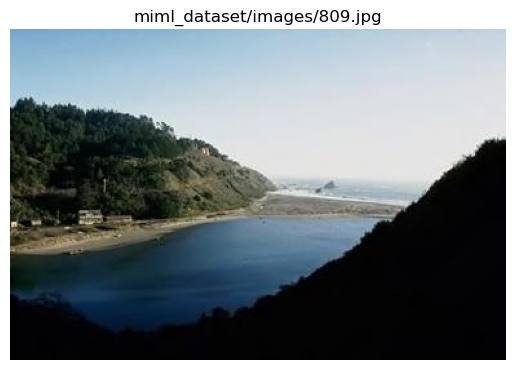

In [ ]:
# Load saved classifier
classifier = Classifier.load("best_classifier.json", val_transforms, device)

# Image to test on
test_image_path = "miml_dataset/images/809.jpg" 
test_image = Image.open(test_image_path).convert("RGB")

# Display the test image.
plt.imshow(test_image)
plt.axis("off")
plt.title(str(test_image_path))
plt.show()


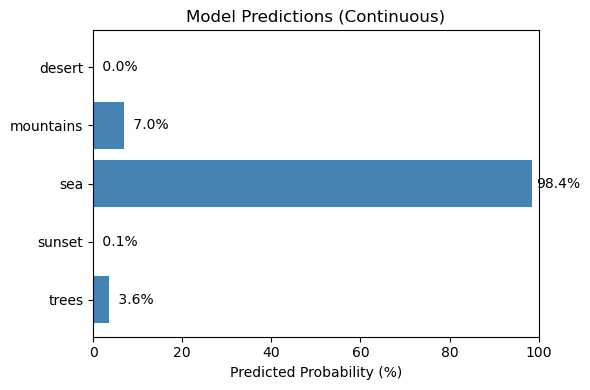

In [ ]:
def predict_probabilities(classifier, input_image):
    """
    Returns continuous prediction probabilities (0 to 1) for each label.
    
    Args:
        classifier (Classifier): The classifier instance.
        input_image (PIL.Image): The input image.
        
    Returns:
        np.array: Array of probabilities for each label.
    """
    tensor_img = classifier.transform(input_image).unsqueeze(0).to(classifier.device)
    with torch.no_grad():
        logits = classifier.model(tensor_img) # Forward pass the image through the model to get raw output logits.
        probabilities = torch.sigmoid(logits) # Apply the sigmoid function to convert logits to probabilities between 0 and 1.
    return probabilities.cpu().numpy()[0]

predicted_probs = predict_probabilities(classifier, test_image) * 100  # Convert to percentages

fig, ax = plt.subplots(figsize=(6, 4))
y_positions = np.arange(len(classifier.categories))
bars = ax.barh(y_positions, predicted_probs, color="steelblue")
ax.set_yticks(y_positions)
ax.set_yticklabels(classifier.categories)
ax.invert_yaxis()  
ax.set_xlim(0, 100)
ax.set_xlabel("Predicted Probability (%)")
ax.set_title("Model Predictions (Continuous)")
for bar in bars:
    bar_width = bar.get_width()
    ax.text(bar_width + 1, bar.get_y() + bar.get_height()/2,
            f"{bar_width:4.1f}%", va="center", ha="left", fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
# Now perform single image evaluation.
predictions = classifier.predict(test_image)
print("Predictions for the test image:", predictions)

# Compare to truth labels
test_key = os.path.splitext(os.path.basename(test_image_path))[0]
test_row = df[df["Filenames"].apply(lambda fname: os.path.splitext(fname)[0]) == test_key]

print(test_row)


Predictions for the test image: [[0. 0. 1. 0. 0.]]
    Filenames  desert  mountains  sea  sunset  trees
808   809.jpg       0          1    1       0      0


###########################################################################################################################
###########################################################################################################################
# ARCHIVE

## Some References

Guide: 

https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24


Associated Dataset:

https://www.dropbox.com/scl/fi/1tck9b8bab8z3n38m7jio/miml_dataset.zip?rlkey=11nwt23wa40o8iqmp24898d3g&e=5&dl=0 



In [ ]:
image_classifier = Classifier(model, data_transforms, device, threshold=0.5, categories=label_columns)
image_classifier.save("best_classifier")

## Inference/Deploying

/opt/anaconda3/envs/360deg_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/360deg_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from best_classifier.pt and best_classifier.json.


/var/folders/7x/5b522k5d54399p2y15rk22kh0000gn/T/ipykernel_96896/2901753385.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(stat

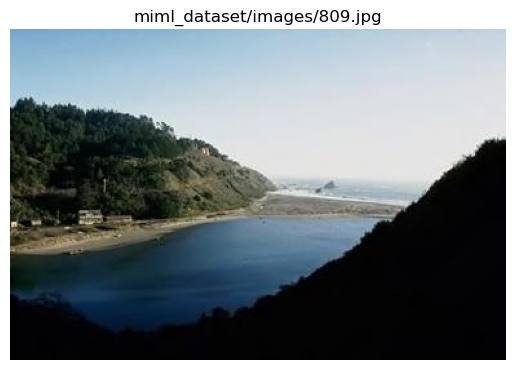

In [31]:
# Load saved classifier
classifier = Classifier.load("best_classifier.json", data_transforms, device)

# Image to test on
test_image_path = "miml_dataset/images/809.jpg" 
test_image = Image.open(test_image_path).convert("RGB")

# Display the test image.
plt.imshow(test_image)
plt.axis("off")
plt.title(str(test_image_path))
plt.show()


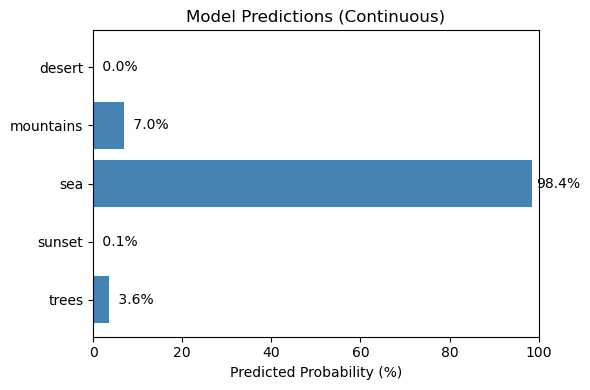

In [84]:
def predict_probabilities(classifier, input_image):
    """
    Returns continuous prediction probabilities (0 to 1) for each label.
    
    Args:
        classifier (Classifier): The classifier instance.
        input_image (PIL.Image): The input image.
        
    Returns:
        np.array: Array of probabilities for each label.
    """
    tensor_img = classifier.transform(input_image).unsqueeze(0).to(classifier.device)
    with torch.no_grad():
        logits = classifier.model(tensor_img) # Forward pass the image through the model to get raw output logits.
        probabilities = torch.sigmoid(logits) # Apply the sigmoid function to convert logits to probabilities between 0 and 1.
    return probabilities.cpu().numpy()[0]

predicted_probs = predict_probabilities(classifier, test_image) * 100  # Convert to percentages

fig, ax = plt.subplots(figsize=(6, 4))
y_positions = np.arange(len(classifier.categories))
bars = ax.barh(y_positions, predicted_probs, color="steelblue")
ax.set_yticks(y_positions)
ax.set_yticklabels(classifier.categories)
ax.invert_yaxis()  
ax.set_xlim(0, 100)
ax.set_xlabel("Predicted Probability (%)")
ax.set_title("Model Predictions (Continuous)")
for bar in bars:
    bar_width = bar.get_width()
    ax.text(bar_width + 1, bar.get_y() + bar.get_height()/2,
            f"{bar_width:4.1f}%", va="center", ha="left", fontsize=10)
plt.tight_layout()
plt.show()


In [85]:
# Now perform single image evaluation.
predictions = classifier.predict(test_image)
print("Predictions for the test image:", predictions)

# Compare to truth labels
test_key = os.path.splitext(os.path.basename(test_image_path))[0]
test_row = df[df["Filenames"].apply(lambda fname: os.path.splitext(fname)[0]) == test_key]

print(test_row)


Predictions for the test image: [[0. 0. 1. 0. 0.]]
    Filenames  desert  mountains  sea  sunset  trees
808   809.jpg       0          1    1       0      0


###########################################################################################################################
###########################################################################################################################
# ARCHIVE

## Some References

Guide: 

https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24



